In [0]:
import torch
import pdb
import torch.nn as nn
import math
from torch.autograd import Variable
from torch.autograd import Function
import time

import numpy as np


def Binarize(tensor,quant_mode='det'):
    if quant_mode=='det':
        return tensor.sign()
    else:
        return tensor.add_(1).div_(2).add_(torch.rand(tensor.size()).add(-0.5)).clamp_(0,1).round().mul_(2).add_(-1)




class HingeLoss(nn.Module):
    def __init__(self):
        super(HingeLoss,self).__init__()
        self.margin=1.0

    def hinge_loss(self,input,target):
            #import pdb; pdb.set_trace()
            output=self.margin-input.mul(target)
            output[output.le(0)]=0
            return output.mean()

    def forward(self, input, target):
        return self.hinge_loss(input,target)

class SqrtHingeLossFunction(Function):
    def __init__(self):
        super(SqrtHingeLossFunction,self).__init__()
        self.margin=1.0

    def forward(self, input, target):
        output=self.margin-input.mul(target)
        output[output.le(0)]=0
        self.save_for_backward(input, target)
        loss=output.mul(output).sum(0).sum(1).div(target.numel())
        return loss

    def backward(self,grad_output):
       input, target = self.saved_tensors
       output=self.margin-input.mul(target)
       output[output.le(0)]=0
       import pdb; pdb.set_trace()
       grad_output.resize_as_(input).copy_(target).mul_(-2).mul_(output)
       grad_output.mul_(output.ne(0).float())
       grad_output.div_(input.numel())
       return grad_output,grad_output

def Quantize(tensor,quant_mode='det',  params=None, numBits=8):
    tensor.clamp_(-2**(numBits-1),2**(numBits-1))
    if quant_mode=='det':
        tensor=tensor.mul(2**(numBits-1)).round().div(2**(numBits-1))
    else:
        tensor=tensor.mul(2**(numBits-1)).round().add(torch.rand(tensor.size()).add(-0.5)).div(2**(numBits-1))
        quant_fixed(tensor, params)
    return tensor

import torch.nn._functions as tnnf


class BinarizeLinear(nn.Linear):

    def __init__(self, *kargs, **kwargs):
        super(BinarizeLinear, self).__init__(*kargs, **kwargs)

    def forward(self, input):

        if input.size(1) != 784:
            input.data=Binarize(input.data)
        if not hasattr(self.weight,'org'):
            self.weight.org=self.weight.data.clone()
        self.weight.data=Binarize(self.weight.org)
        out = nn.functional.linear(input, self.weight)
        if not self.bias is None:
            self.bias.org=self.bias.data.clone()
            out += self.bias.view(1, -1).expand_as(out)

        return out

class BinarizeConv2d(nn.Conv2d):

    def __init__(self, *kargs, **kwargs):
        super(BinarizeConv2d, self).__init__(*kargs, **kwargs)


    def forward(self, input):
        if input.size(1) != 3:
            input.data = Binarize(input.data)
        if not hasattr(self.weight,'org'):
            self.weight.org=self.weight.data.clone()
        self.weight.data=Binarize(self.weight.org)

        out = nn.functional.conv2d(input, self.weight, None, self.stride,
                                   self.padding, self.dilation, self.groups)

        if not self.bias is None:
            self.bias.org=self.bias.data.clone()
            out += self.bias.view(1, -1, 1, 1).expand_as(out)

        return out
      



In [0]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from tqdm import tqdm
# from models.binarized_modules import  BinarizeLinear,BinarizeConv2d
# from models.binarized_modules import  Binarize,Ternarize,Ternarize2,Ternarize3,Ternarize4,HingeLoss
# Training settings
# parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
# parser.add_argument('--batch-size', type=int, default=64, metavar='N',
#                     help='input batch size for training (default: 256)')
# parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
#                     help='input batch size for testing (default: 1000)')
# parser.add_argument('--epochs', type=int, default=100, metavar='N',
#                     help='number of epochs to train (default: 10)')
# parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
#                     help='learning rate (default: 0.001)')
# parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
#                     help='SGD momentum (default: 0.5)')
# parser.add_argument('--no-cuda', action='store_true', default=False,
#                     help='disables CUDA training')
# parser.add_argument('--seed', type=int, default=1, metavar='S',
#                     help='random seed (default: 1)')
# parser.add_argument('--gpus', default=3,
#                     help='gpus used for training - e.g 0,1,3')
# parser.add_argument('--log-interval', type=int, default=10, metavar='N',
#                     help='how many batches to wait before logging training status')
# args = parser.parse_args()
# args.cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(1)
# if args.cuda:
#     torch.cuda.manual_seed(args.seed)


# kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=128, shuffle=True)


# 32C3 - MP2 - 64C3 - Mp2 - 512FC - SM10

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
    
        self.conv1 = BinarizeConv2d(1, 32, kernel_size=3)
        self.mp1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.htanh1 = nn.Hardtanh()
        
        self.conv2 = BinarizeConv2d(32, 64, kernel_size=3)
        self.mp2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.htanh2 = nn.Hardtanh()
        
        self.fc1 = nn.Linear(64*5*5, 512)
        self.bn3 = nn.BatchNorm1d(512)
        self.htanh3 = nn.Hardtanh()
        
        self.fc2 = nn.Linear(512, 10)
        self.sm = nn.Softmax(dim=1)
        
          

    def forward(self, x):

        x = self.conv1(x)
        x = self.mp1(x)
        x = self.bn1(x)
        x = self.htanh1(x)

        
        x = self.conv2(x)
        x = self.mp2(x)
        x = self.bn2(x)
        x = self.htanh2(x)

        x = x.view(x.size(0), -1)
        
        
        x = self.fc1(x)
        x = self.bn3(x)
        x = self.htanh3(x)
        
        x = self.fc2(x)
     

        return self.sm(x)

model = Net()
torch.cuda.device('cuda')
model.cuda()


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


def train(epoch):
    model.train()
    
    losses = []
    trainloader = tqdm(train_loader)
    
    for batch_idx, (data, target) in enumerate(trainloader):
 
        data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)

        if epoch%40==0 and epoch != 0:
            optimizer.param_groups[0]['lr']=optimizer.param_groups[0]['lr']*0.1

        
        loss.backward()
    
        for p in list(model.parameters()):
            if hasattr(p,'org'):
                p.data.copy_(p.org)
        optimizer.step()
        
        for p in list(model.parameters()):
            if hasattr(p,'org'):
                p.org.copy_(p.data.clamp_(-1,1))
    
        losses.append(loss.item())
        trainloader.set_postfix(loss=np.mean(losses), epoch=epoch)


loss_history = []
acc_history = []

def test():
    model.eval()
    test_loss = 0
    correct = 0
    testloader = tqdm(test_loader)
    for data, target in testloader:
        data, target = data.cuda(), target.cuda()
        with torch.no_grad():
          data = Variable(data)
        target = Variable(target)
        output = model(data)
        test_loss += criterion(output, target).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
        loss = test_loss / len(test_loader.dataset)
        acc = (100. *correct / len(test_loader.dataset)).numpy()
        
        testloader.set_postfix(loss=loss,acc=str(acc)+'%')
    
    test_loss /= len(test_loader.dataset)
    total_acc = correct.item()/len(test_loader.dataset)
    loss_history.append(test_loss)
    acc_history.append(total_acc)
    



In [0]:
%%%time
for epoch in range(50):
    train(epoch)
    test()

100%|██████████| 79/79 [00:01<00:00, 48.11it/s, acc=98%, loss=0.0117]

CPU times: user 10min 21s, sys: 49.5 s, total: 11min 11s
Wall time: 11min 50s


[0.01190078625679016, 0.011837145018577576, 0.011924525892734527, 0.011737275230884551, 0.011768514847755433, 0.011783999240398408, 0.011706289994716644, 0.011829563319683075, 0.011731088542938233, 0.011716509556770324, 0.011713834750652314, 0.011836355912685394, 0.011734316849708557, 0.011703750383853913, 0.011689415466785431, 0.011694729053974152, 0.011744753849506379, 0.01171423567533493, 0.011683926033973694, 0.01170841315984726, 0.011679772329330445, 0.01169004123210907, 0.011687162482738494, 0.011682812929153442, 0.011710561203956605, 0.011672307455539703, 0.01169718999862671, 0.011677938425540924, 0.011673181986808777, 0.011680014634132384, 0.01167841213941574, 0.011680362713336945, 0.01167221635580063, 0.011702948772907257, 0.011685229635238648, 0.011693143546581268, 0.011652611029148103, 0.011693026876449585, 0.011668342173099517, 0.011701913678646087, 0.011683530354499818, 0.01168459531068802, 0.01168491758108139, 0.011682753574848175, 0.011684403729438781, 0.0116805071592330

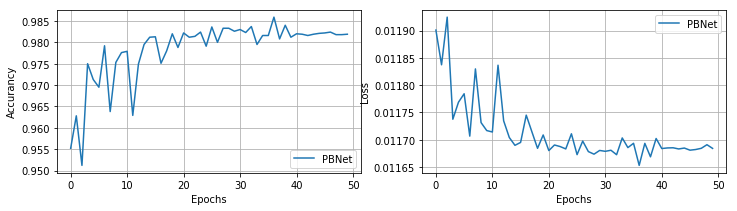

In [0]:
print(loss_history)

print(acc_history)


import numpy as np
import matplotlib.pyplot as plt

f = plt.figure(figsize=(12,3))
ax = f.add_subplot(121)
ax.plot(acc_history,label='PBNet')
ax.grid()
ax.set_ylabel('Accurancy')
ax.set_xlabel('Epochs')
ax.legend(loc='lower right')

ax2 = f.add_subplot(122)
ax2.plot(loss_history,label='PBNet')
ax2.grid()
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epochs')
ax2.legend(loc='upper right')